In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# path = "/Users/charlottemyers/projects/jlab/spectro/data/Nate_Charlotte_929_cal2.txt"
# hg_path = "/Users/charlottemyers/projects/jlab/spectro/data/Nate_Charlotte_929_cal.txt"

hg_path = "/Users/charlottemyers/projects/jlab/spectro/data/Nate_Charlotte_1001_cal1.txt"
ne_path = "/Users/charlottemyers/projects/jlab/spectro/data/Nate_Charlotte_1001_cal2.txt"


In [31]:
df_ne = pd.read_csv(ne_path, sep=r"\s+")
step_ne = df_ne["Monochromator-step"].to_numpy()
cps_ne  = df_ne["cps"].to_numpy()

df_hg = pd.read_csv(hg_path, sep="\t")
df_hg = df_hg.iloc[:, [0, 1]].rename(columns={df_hg.columns[0]: "step", df_hg.columns[1]: "cps"})

step_hg = df_hg["step"].to_numpy()
cps_hg  = df_hg["cps"].to_numpy()

plt.plot(step_ne, cps_ne, lw=1)
plt.plot(step_hg, cps_hg, lw=1)
lines = [
    5852.49,
    6029.99,
    6074.34,
    6143.06,
    #6163.59,
    6217.28,
    6334.43,
    6382.99,
    6402.248,
    #6402.25,
    6506.53,
    6532.8822,
    6598,
    6678.2762,
    6717.0430
]

for line in lines:
    plt.axvline(line - 135, color="gray", ls="--", label = f"{line} nm")

plt.xlim(5200, 6600)
plt.legend(fontsize = 8)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [5]:
# get observed peaks - maximum points in the spectrum - above 5 sigma
observed_peaks = step[cps > np.mean(cps) + 1* np.std(cps)]
print(f"Observed peaks (steps) before averaging: {observed_peaks}")
# if peaks are within 2 angstroms of each other, avergage them
for i in range(len(observed_peaks)-1, 0, -1):
    if observed_peaks[i] - observed_peaks[i-1] < 2:
        avg_peak = (observed_peaks[i] + observed_peaks[i-1]) / 2
        observed_peaks[i-1] = avg_peak
        observed_peaks = np.delete(observed_peaks, i)
print(f"Observed peaks (steps) after averaging: {observed_peaks}")

Observed peaks (steps) before averaging: [5725. 5817. 5902. 5946. 5967. 6014. 6088. 6137. 6175. 6253. 6272. 6402.
 6468. 6547. 6585.]
Observed peaks (steps) after averaging: [5725. 5817. 5902. 5946. 5967. 6014. 6088. 6137. 6175. 6253. 6272. 6402.
 6468. 6547. 6585.]


In [6]:
observed_peaks_hg = step_hg[cps_hg > np.mean(cps_hg) + 1* np.std(cps_hg)]
print(f"Observed Hg peaks (steps) before averaging: {observed_peaks_hg}")
# if peaks are within 2 angstroms of each other, avergage them
for i in range(len(observed_peaks_hg)-1, 0, -1):
    if observed_peaks_hg[i] - observed_peaks_hg[i-1] < 2:
        avg_peak = (observed_peaks_hg[i] + observed_peaks_hg[i-1]) / 2
        observed_peaks_hg[i-1] = avg_peak
        observed_peaks_hg = np.delete(observed_peaks_hg, i)
print(f"Observed Hg peaks (steps) after averaging: {observed_peaks_hg}")

Observed Hg peaks (steps) before averaging: [4237 5335 5664]
Observed Hg peaks (steps) after averaging: [4237 5335 5664]


In [7]:
def match_and_fit_poly(observed_peaks, ref_wl, deg=3, tol=8.0, offset0=None):
    obs = np.asarray(observed_peaks, float)
    ref = np.asarray(ref_wl, float)

    if offset0 is None:
        j = np.argmin(np.abs(obs[:, None] - ref[None, :]), axis=1)
        offset0 = np.median(obs - ref[j])

    # nearest matches with one-to-one selection
    pred_steps = ref - offset0
    d = np.abs(obs[:, None] - pred_steps[None, :])
    pairs = np.array(np.unravel_index(np.argsort(d, axis=None), d.shape)).T

    used_obs = set(); used_ref = set()
    matched_obs, matched_ref = [], []
    for io, ir in pairs:
        if d[io, ir] > tol: break
        if io in used_obs or ir in used_ref: continue
        used_obs.add(io); used_ref.add(ir)
        matched_obs.append(obs[io]); matched_ref.append(ref[ir])

    matched_obs = np.array(matched_obs)
    matched_ref = np.array(matched_ref)

    if len(matched_obs) < deg + 1:
        raise RuntimeError(f"Not enough matches ({len(matched_obs)}) for degree {deg} fit. Increase tol or add lines.")

    # polynomial fit
    coeff = np.polyfit(matched_obs, matched_ref, deg)
    p = np.poly1d(coeff)

    # residuals at matched peaks
    resid = matched_ref - p(matched_obs)
    rms = np.sqrt(np.mean(resid**2))

    return p, coeff, matched_obs, matched_ref, resid, rms

ne_lines = np.array([
    5852.4879, 6029.9969, 6074.3377, 6143.0626, 6163.5939,
    6217.2812, 6266.4950, 6334.4278, 6382.9917, 6402.2480,
    6506.5281, 6598.9529, 6678.2762, 6717.0430, 6929.4673,
    7032.4131, 7173.9381, 7245.1666], dtype=float)

hg_lines = np.array([
    4046.563, 4358.335, 5460.735, 5769.598, 5790.663,
    6234.062, 6907.473, 7065.190, 7281.348], dtype=float)

observed_total = np.concatenate([observed_peaks, observed_peaks_hg])
known_lines = np.concatenate([ne_lines, hg_lines])

# --- run it ---
p, coeff, m_obs, m_ref, resid, rms = match_and_fit_poly(observed_total, known_lines, deg=2, tol=15.0, offset0=135.0)
print("λ(step) = ", " + ".join(f"{c:.6g}*step^{i}" for i, c in zip(range(len(coeff)-1, -1, -1), coeff)))
print(f"Matches: {len(m_obs)}, RMS = {rms:.3f} Å")

fit_function = p
def p(x): return fit_function(x)
#  match table
match_tbl = pd.DataFrame({
    "Ref λ (Å)": m_ref,
    "Obs step": m_obs,
    "Pred λ from fit": p(m_obs),
    "Residual (Å)": resid
}).sort_values("Ref λ (Å)")
print(match_tbl.to_string(index=False, float_format=lambda x: f"{x:10.3f}"))

λ(step) =  4.64656e-07*step^2 + 0.999422*step^1 + 115.444*step^0
Matches: 14, RMS = 0.206 Å
 Ref λ (Å)   Obs step  Pred λ from fit  Residual (Å)
  4358.335   4237.000         4358.335         0.000
  5460.735   5335.000         5460.584         0.151
  5790.663   5664.000         5791.075        -0.412
  5852.488   5725.000         5852.362         0.126
  6029.997   5902.000         6030.216        -0.219
  6074.338   5946.000         6074.433        -0.095
  6143.063   6014.000         6142.771         0.291
  6217.281   6088.000         6217.145         0.136
  6266.495   6137.000         6266.395         0.100
  6382.992   6253.000         6382.996        -0.004
  6402.248   6272.000         6402.095         0.153
  6598.953   6468.000         6599.142        -0.189
  6678.276   6547.000         6678.574        -0.298
  6717.043   6585.000         6716.784         0.259


In [99]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].plot(step, cps, lw=1, label="Ne spectrum")
# ax[0].plot(step_hg, cps_hg, lw=1, label="Hg spectrum", color="orange")
# ax[0].legend(frameon=False)
# ax[0].plot(m_obs, cps[np.searchsorted(step, m_obs)], label="Matched peaks", ms=4)
# ax[0].set_xlabel("Monochromator step")

# # plot residuals
# ax[1].hlines(0, np.min(m_obs), np.max(m_obs), color="gray", ls="--")
# ax[1].plot(m_obs, resid, "o-")
# ax[1].set_xlabel("Observed step")
# ax[1].set_ylabel("Residual (Å)")
# ax[1].set_title("Fit Residuals")

In [ ]:
# --- greedy nearest one-to-one matching with a coarse offset ---

def _match_one_spectrum(obs_peaks, ref_wl, label, tol=10.0, offset0=None):
    obs = np.asarray(obs_peaks, float)
    ref = np.asarray(ref_wl, float)
    # coarse offset: obs ~ ref + offset
    if offset0 is None:
        j = np.argmin(np.abs(obs[:, None] - ref[None, :]), axis=1)
        offset0 = np.median(obs - ref[j])

    pred_steps = ref + offset0
    d = np.abs(obs[:, None] - pred_steps[None, :])
    order = np.argsort(d, axis=None)
    used_o = set(); used_r = set()
    m_obs, m_ref, lab = [], [], []

    for k in order:
        io, ir = divmod(k, d.shape[1])
        if d[io, ir] > tol: break
        if io in used_o or ir in used_r:
            continue
        used_o.add(io); used_r.add(ir)
        m_obs.append(obs[io]); m_ref.append(ref[ir]); lab.append(label)

    return np.array(m_obs), np.array(m_ref), np.array(lab), float(offset0)

# --- match both spectra, fit polynomial, build outputs ---
def calibrate_two_spectra(
    obs_peaks_ne, ref_ne,
    obs_peaks_hg, ref_hg,
    deg=3, tol=15.0, shared_offset=None
):
    m_ne_obs, m_ne_ref, lbl_ne, off_ne = _match_one_spectrum(
        obs_peaks_ne, ref_ne, "Ne", tol=tol, offset0=shared_offset
    )
    m_hg_obs, m_hg_ref, lbl_hg, off_hg = _match_one_spectrum(
        obs_peaks_hg, ref_hg, "Hg", tol=tol, offset0=shared_offset
    )

    m_obs = np.concatenate([m_ne_obs, m_hg_obs])
    m_ref = np.concatenate([m_ne_ref, m_hg_ref])
    labels = np.concatenate([lbl_ne, lbl_hg])

    if len(m_obs) < deg + 1:
        raise RuntimeError(f"Only {len(m_obs)} matches; need at lest {deg+1} for a degree-{deg} fit. Increase tol or add lines.")

    coeff = np.polyfit(m_obs, m_ref, deg)
    p = np.poly1d(coeff)
    resid = m_ref - p(m_obs)
    rms = float(np.sqrt(np.mean(resid**2)))

    match_tbl = pd.DataFrame(
        {"species": labels, "Ref λ (Å)": m_ref, "Obs step": m_obs,
         "λ_fit(Obs step)": p(m_obs), "Residual (Å)": resid}
    ).sort_values(["species", "Ref λ (Å)"])

    return p, coeff, match_tbl, rms, {"offset_ne": off_ne, "offset_hg": off_hg}

def _poly_str(coeff):
    n = len(coeff) - 1
    terms = []
    for i, c in enumerate(coeff):
        pwr = n - i
        if pwr == 0:
            terms.append(f"{c:.6g}")
        elif pwr == 1:
            terms.append(f"{c:.6g}·step")
        else:
            terms.append(f"{c:.6g}·step^{pwr}")
    return "λ(step) = " + " + ".join(terms)

# --- run calibration ---
# observed_peaks, observed_peaks_hg, ne_lines, hg_lines
p, coeff, match_tbl, rms, offsets = calibrate_two_spectra(
    observed_peaks, ne_lines,
    observed_peaks_hg, hg_lines,
    deg=2, tol=15.0, shared_offset=-135.0
)

print(_poly_str(coeff))
print(f"RMS = {rms:.2f} Å   N = {len(match_tbl)}   offsets: {offsets}")
print(match_tbl.to_string(index=False, float_format=lambda x: f"{x:10.3f}"))


λ(step) = 4.64656e-07·step^2 + 0.999422·step + 115.444
RMS = 0.21 Å   N = 14   offsets: {'offset_ne': -135.0, 'offset_hg': -135.0}
species  Ref λ (Å)   Obs step  λ_fit(Obs step)  Residual (Å)
     Hg   4358.335   4237.000         4358.335         0.000
     Hg   5460.735   5335.000         5460.584         0.151
     Hg   5790.663   5664.000         5791.075        -0.412
     Ne   5852.488   5725.000         5852.362         0.126
     Ne   6029.997   5902.000         6030.216        -0.219
     Ne   6074.338   5946.000         6074.433        -0.095
     Ne   6143.063   6014.000         6142.771         0.291
     Ne   6217.281   6088.000         6217.145         0.136
     Ne   6266.495   6137.000         6266.395         0.100
     Ne   6382.992   6253.000         6382.996        -0.004
     Ne   6402.248   6272.000         6402.095         0.153
     Ne   6598.953   6468.000         6599.142        -0.189
     Ne   6678.276   6547.000         6678.574        -0.298
     Ne   6717.

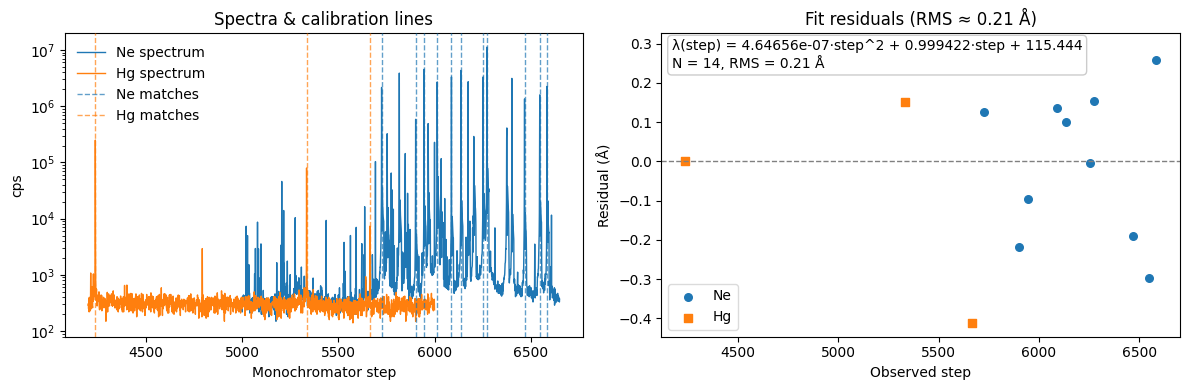

In [15]:
# --- plots: spectra + matched peaks, and residuals colored by species ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# left: raw spectra with matched vertical lines at matched peaks
ax[0].plot(step,    cps,    lw=1, label="Ne spectrum")
ax[0].plot(step_hg, cps_hg, lw=1, label="Hg spectrum")

mask_ne = match_tbl["species"].to_numpy() == "Ne"
mask_hg = ~mask_ne
m_obs   = match_tbl["Obs step"].to_numpy()

ne_color = ax[0].lines[0].get_color()
hg_color = ax[0].lines[1].get_color()

first = True
for x in m_obs[mask_ne]:
    ax[0].axvline(x, color=ne_color, ls="--", lw=1.0, alpha=0.7, zorder=3,
                  label="Ne matches" if first else None)
    first = False

first = True
for x in m_obs[mask_hg]:
    ax[0].axvline(x, color=hg_color, ls="--", lw=1.0, alpha=0.7, zorder=3,
                  label="Hg matches" if first else None)
    first = False

ax[0].set_xlabel("Monochromator step")
ax[0].set_ylabel("cps")
ax[0].set_title("Spectra & calibration lines")
ax[0].legend(frameon=False, loc="best")
ax[0].set_yscale("log")

# right: residuals by species
resid = match_tbl["Residual (Å)"].to_numpy()
ax[1].axhline(0, lw=1, ls="--", color="gray")
ax[1].scatter(m_obs[mask_ne], resid[mask_ne], s=30, marker="o", label="Ne")
ax[1].scatter(m_obs[mask_hg], resid[mask_hg], s=30, marker="s", label="Hg")
ax[1].set_xlabel("Observed step")
ax[1].set_ylabel("Residual (Å)")
ax[1].set_title(f"Fit residuals (RMS ≈ {rms:.2f} Å)")
ax[1].legend(frameon=True, loc="best", framealpha=0.7)
# log scale

# annotate polynomial on residual plot
ax[1].text(
    0.02, 0.98,
    _poly_str(coeff) + f"\nN = {len(match_tbl)}, RMS = {rms:.2f} Å",
    transform=ax[1].transAxes, va="top", ha="left",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8")
)

plt.tight_layout()

plt.show()

In [ ]:
## saved calibration functions (list of params)

import pickle
calib_data_929 = {
    "929": {
        "coeff": coeff,
        "function": p,
        "order": 2
    }
}

# calib_data_101 = {
#     "101": {
#         "coeff": [ 2.06127e-03, -1.35349e+00,  2.63436e+03],
#         "function": lambda x: 2.06127e-03*x**2 - 1.35349e+00*x + 2.63436e+03,
#         "order": 2

# with open("/Users/charlottemyers/projects/jlab/spectro/cal_functions.pkl", "wb") as f:
#     pickle.dump(calib_data, f)